# Data Cleaning TEMPLATE

In [1]:
# Libraries

## Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns

import math
from numpy import mean 
from numpy import std
from numpy import percentile 
# from scipy.stats import iqr

## Plotting
import matplotlib.pyplot as plt

# Basic cleaning
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.metrics import mean_absolute_error 

## Basic data cleaning

🔍 **Why Data Cleaning Matters**
- Essential in every ML project; often skipped at a cost.
- Prevents model failure and misleading performance results.
- Helps prepare trustworthy, high-quality datasets.

In [2]:
# Load datasets
# Paths
calorie_train_data_path = "../../data/raw_data/train.csv"

# Read train data
data=pd.read_csv(calorie_train_data_path,index_col='id')
display(f"Shape of data : {data.shape}")

'Shape of data : (750000, 8)'

In [3]:
# Copy of datasets
data_copy = data.copy()

In [4]:
# Overview of the first lines
data.head(2)

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
id                                                                        
0     male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   female   64   163.0    60.0       8.0        85.0       39.7      34.0

### Identify Columns That Contain a Single Value

🧮 **Identify Columns with a Single Unique Value**
- **Problem**: Zero-variance predictors (e.g., all values = 1.0).
- **Detection**: Use .nunique() or NumPy’s unique() function.
- **Action**: Remove these columns—they add no information and can cause errors.

In [5]:
# Summurize the number of unique values in each column
data.nunique()

Sex             2
Age            60
Height         86
Weight         91
Duration       30
Heart_Rate     63
Body_Temp      75
Calories      277
dtype: int64

**CONCLUSION**:

### Delete Columns That Contain a Single Value

🗑️ **Delete Columns with a Single Value**
- Use Pandas drop() after identifying the column(s).


In [6]:
# Create a function to drop columns that have a single value
def drop_single_value_columns(df : pd.DataFrame) -> pd.DataFrame:
        """
    Drop columns with a single unique value 
    Args:
        df (DataFrame): Raw data
    Returns:
        df (DataFrame) with no single value columns
    """ 
        print(f"Shape BEFORE dropping single value columns: {df.shape}") 
        
        # get number of unique values for each column 
        counts = df.nunique()
        
        # record columns to delete (i.e columns that only contain a unique value)
        to_del = [i for i,v in enumerate(counts) if v == 1]
    
        print(f"Names of single value columns: {to_del}") 
        
        # drop useless columns 
        df.drop(to_del, axis=1, inplace=True) 
        
        print(f"Shape AFTER dropping single value columns: {df.shape}") 
        return df

In [7]:
data = drop_single_value_columns(data)

Shape BEFORE dropping single value columns: (750000, 8)
Names of single value columns: []
Shape AFTER dropping single value columns: (750000, 8)


**CONCLUSION**:

### Consider Columns That Have Very Few Values

🤔 **Consider Columns with Very Few Unique Values**
- Known as **near-zero** variance predictors.
- These may be:<br>
o	Categorical in disguise.<br>
o	Indicators needing encoding (ordinal/categorical).
- **Check**: Unique values as % of total rows (e.g., <1%).


In [8]:
# Create a function that print index, number of unique values and percentage of unique values per column in regard to total number of rows per column
def show_unique_values_percentage(df : pd.DataFrame):
    """
    Print index, number of unique values and percentage of unique values 
    per column in regard to total number of rows per column
    Args:
        - df (DataFrame): Raw data
    """  
    for i in range(df.shape[1]):
        num = df.nunique().values[i]
        percentage = float(num) / df.shape[0] * 100
        print(f"{i}, {df.columns[i]}, {num}, {round(percentage,5)}%")

In [9]:
show_unique_values_percentage(data)

0, Sex, 2, 0.00027%
1, Age, 60, 0.008%
2, Height, 86, 0.01147%
3, Weight, 91, 0.01213%
4, Duration, 30, 0.004%
5, Heart_Rate, 63, 0.0084%
6, Body_Temp, 75, 0.01%
7, Calories, 277, 0.03693%


**CONCLUSION**:

### Remove columns that have a low variance

✂️ **Remove Columns with Low Variance**
- Use **VarianceThreshold** from sklearn.feature_selection.
- **Threshold Tuning**: Try 0.0 to 0.5; see feature reduction effects.
- Lower variance = less informational value, possibly noise.
- Helps dimensionality reduction while retaining meaningful features.

In [10]:
# explore the effect of the variance thresholds on the number of selected features 
def explore_variance_threshold_effects(df : pd.DataFrame, range : np.arange):
    """
    Explore the effect of the variance thresholds on 
    the number of selected features from numpy import arange 
    Args:
        - df (DataFrame): Raw data
        - range (np.arange) : variance range to check
    Returns:
        - Print number of features whose variance is over the considered threshold
        - Plot the number of features whose variance is over the considered threshold
    """ 
    
    # apply transform with each threshold 
    results = list() 

    for t in range: 
        # define the transform 
        transform = VarianceThreshold(threshold=t) 
        
        # transform the input data 
        df_sel = transform.fit_transform(df) 
        
        # determine the number of input features 
        n_features = df_sel.shape[1] 
        
        print(f">Threshold={round(t,2)}, Features={n_features}")
        
        # store the result 
        results.append(n_features) 
        
    # plot the threshold vs the number of selected features 
    plt.plot(range, results) 
    plt.show()

(750000, 7) (750000, 1)
>Threshold=0.0, Features=6
>Threshold=0.05, Features=6
>Threshold=0.1, Features=6
>Threshold=0.15, Features=6
>Threshold=0.2, Features=6
>Threshold=0.25, Features=6
>Threshold=0.3, Features=6
>Threshold=0.35, Features=6
>Threshold=0.4, Features=6
>Threshold=0.45, Features=6


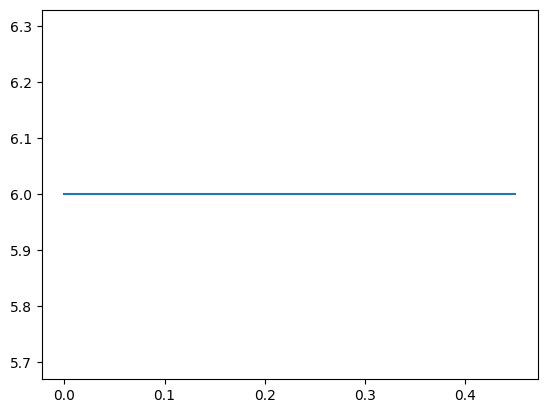

In [11]:
# split data into inputs (ONLY NUMERICAL FOR NOW) and outputs 
data_num = data.select_dtypes(include="number")

# Define X and y
target = 'Calories'
X = data.drop(columns=[target])
y = data[[target]]
print(X.shape, y.shape) 

# Only use the numerical columns of X
X_num = X.select_dtypes(include='number')

# define variance thresholds to check 
# thresholds = np.arange(0.0, 0.55, 0.05) 
thresholds = np.arange(0.0, 0.5, 0.05) 

explore_variance_threshold_effects(X_num, thresholds)

**CONCLUSION**:

### Identify rows that contain duplicate data

🧍 **Identify Duplicate Rows**
- **Problem**: Inflated priors, biased evaluation (e.g., in cross-validation).
- **Action**: Check .duplicated() in Pandas.
- **Best Practice**: Test model performance with/without duplicates.

In [12]:
# calculate duplicates 
dups = data.duplicated() 

# report if there are any duplicates 
print(f"Is there any duplicated rows in the dataset ? Answer : {dups.any()}") 

# list all duplicate rows 
print(data[dups])

Is there any duplicated rows in the dataset ? Answer : True
           Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
id                                                                            
11643   female   54   161.0    61.0      14.0        95.0       40.3      76.0
18100   female   54   161.0    61.0       9.0        88.0       39.7      42.0
22070     male   51   187.0    94.0       3.0        81.0       38.8      10.0
26664   female   67   169.0    69.0      24.0       104.0       40.7     161.0
31062   female   40   161.0    58.0      14.0        90.0       40.4      64.0
...        ...  ...     ...     ...       ...         ...        ...       ...
749584  female   39   161.0    61.0      13.0        99.0       40.3      74.0
749823  female   29   173.0    68.0      14.0        95.0       40.2      67.0
749852    male   21   187.0    90.0       9.0        91.0       39.7      30.0
749889    male   40   191.0    88.0       5.0        86.0       39.0   

**CONCLUSION**:

### Delete rows that contain duplicate data

In [13]:
def check_duplicates(df):
    """
    Counts duplicated rows. If any, function drops duplicated rows.
    Args:
        df (DataFrame): Raw data
    Returns:
        - df (Dataframe) without duplicated rows, a string otherwise.
    """

    # Check number of rows before removing duplicates
    print(f"Number of rows : {len(df)}")

    # Compute the number of duplicated rows
    num_dups = df.duplicated().sum()
    
    print(f"Number of duplicated rows : {num_dups}")

    if df.duplicated().any():
        # Remove duplicates
        df_no_duplicates = df.drop_duplicates()
        print(f"{num_dups} duplicated row(s) removed")
        return df_no_duplicates
    else:
        return "No duplicated rows found !"    

In [14]:
# Check for duplicates ; if found, duplicates are dropped.
data_no_dups = check_duplicates(data)

Number of rows : 750000
Number of duplicated rows : 2841
2841 duplicated row(s) removed


## Outlier Identification and Removal

✅ **Why Care About Outliers?**
- Outliers = observations significantly different from others.
- Can distort models, reduce performance.
- Causes: measurement error, data corruption, or genuine anomaly.

#### Standard Deviation Method

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers. 

📌 **Standard Deviation Method**
- **Assumes Gaussian (normal) distribution.**
- **Key concept**: Most data falls within a range of standard deviations from the mean:<br>
o	±1 std = 68%<br>
o	±2 std = 95%<br>
o	±3 std = 99.7%<br>
- Outliers = values > 3 standard deviations from the mean.
- **Steps**:
1.	Calculate mean and std.
2.	Compute cut-off bounds: mean ± 3*std.
3.	Filter out values outside these bounds.

In [15]:
# Load datasets
# Paths
calorie_train_data_path = "../../data/raw_data/train.csv"

# Read train data
data=pd.read_csv(calorie_train_data_path,index_col='id')
display(f"Shape of data : {data.shape}")

'Shape of data : (750000, 8)'

In [16]:
# If distribution Gaussian or Gaussian-like, we use the standard deviation of the sample as a cut-off for identifying outliers
def identify_outliers_std_dev_method(data : pd.DataFrame):
    """
    If distribution Gaussian or Gaussian-like, we use the standard deviation of the sample as a cut-off for identifying outliers
    Args:
        data (pd.Dataframe): Raw data
    Returns:
        - columns_with_outliers (list) : Numerical Columns containing outliers
        - columns_no_outliers (list) : Numerical Columns NOT containing outliers
    """

    # Deal ONLY with numerical columns
    data = data.select_dtypes(include='number')

    columns_with_outliers, columns_no_outliers = [], []
    
    for col in data.columns.tolist():
        # calculate summary statistics 
        data_mean, data_std = mean(data[col]), std(data[col]) 

        # define outliers 
        cut_off = data_std * 3 
        lower, upper = data_mean - cut_off, data_mean + cut_off 

        # identify outliers 
        outliers = [x for x in data[col] if x < lower or x > upper] 
       
        # remove outliers
        outliers_removed = [x for x in data[col] if x >= lower and x <= upper]

        if len(outliers) > 0:
            columns_with_outliers.append(col)
        else:
            columns_no_outliers.append(col)

    return columns_with_outliers, columns_no_outliers

In [17]:
# identify outliers with standard deviation 
columns_with_outliers_std_method, columns_no_outliers_std_method = identify_outliers_std_dev_method(data)
display(columns_with_outliers_std_method)
display(columns_no_outliers_std_method)

['Height', 'Weight', 'Heart_Rate', 'Body_Temp', 'Calories']

['Age', 'Duration']

**CONCLUSION**:

#### Interquartile Range Method 

📌 **Interquartile Range (IQR) Method**
- **Useful when data is not Gaussian.**
- **IQR** = Q3 - Q1 (75th percentile - 25th percentile).
- **Outliers** = values < Q1 - 1.5×IQR or > Q3 + 1.5×IQR.
- Can detect both mild and extreme outliers (by adjusting the factor, e.g., 1.5 or 3).
- **Steps**:
1.	Compute Q1 and Q3 using percentiles.
2.	Calculate IQR.
3.	Define bounds: Q1 - 1.5×IQR and Q3 + 1.5×IQR.
4.	Filter out values outside these limits.

In [18]:
# Load datasets
# Paths
calorie_train_data_path = "../../data/raw_data/train.csv"

# Read train data
data=pd.read_csv(calorie_train_data_path,index_col='id')
display(f"Shape of data : {data.shape}")

'Shape of data : (750000, 8)'

In [19]:
# identify outliers with interquartile range 
def identify_outliers_iqr_method(data : pd.DataFrame):
    """
    A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.
    This function identifies outliers with interquartile range (iqr).
    Args:
        data (pd.DataFrame): Raw data
    Returns:
        - outliers (ndarray) : only identified outliers
        - outliers_removed (ndarray) : data with outliers removed
    """

    # Deal ONLY with numerical columns
    data = data.select_dtypes(include='number')

    columns_with_outliers, columns_no_outliers = [], []

    for col in data.columns.tolist():
        # calculate interquartile range 
        q25, q75 = percentile(data[col], 25), percentile(data[col], 75) 
        iqr = q75 - q25 
        
        # calculate the outlier cutoff 
        cut_off = iqr * 1.5 
        lower, upper = q25 - cut_off, q75 + cut_off 
        
        # identify outliers 
        outliers = [x for x in data[col] if x < lower or x > upper] 
        
        # remove outliers 
        outliers_removed = [x for x in data[col] if x >= lower and x <= upper]
        
        if len(outliers) > 0:
            columns_with_outliers.append(col)
        else:
            columns_no_outliers.append(col)
    
    return columns_with_outliers, columns_no_outliers

In [20]:
# identify outliers with interquartile range 
columns_with_outliers_iqr_method, columns_no_outliers_iqr_method = identify_outliers_iqr_method(data)
display(columns_with_outliers_iqr_method)
display(columns_no_outliers_iqr_method)

['Height', 'Weight', 'Heart_Rate', 'Body_Temp', 'Calories']

['Age', 'Duration']

**CONCLUSION**:

#### Automatic Outlier Detection 

🔍 **Local Outlier Factor (LOF)**
- **Good for multivariate**,**non-Gaussian data**.
- Measures local deviation based on nearest neighbors.
- Assigns score: high score = high likelihood of being an outlier.
- **Tool**: sklearn.neighbors.LocalOutlierFactor.

In [21]:
# Load datasets
# Paths
calorie_train_data_path = "../../data/raw_data/train.csv"

# Read train data
data=pd.read_csv(calorie_train_data_path,index_col='id')
display(f"Shape of data : {data.shape}")

'Shape of data : (750000, 8)'

In [22]:
# evaluate model on training dataset with outliers removed 

# split into input and output elements
target="Calories"
X, y = data.drop(columns=target), data[[target]]

# Only take numerical columns into account HERE
X = X.select_dtypes(include="number")

# split into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) 

# summarize the shape of the training dataset 
print(X_train.shape, y_train.shape) 

# identify outliers in the training dataset 
# lof = LocalOutlierFactor()
lof = IsolationForest() 
yhat = lof.fit_predict(X_train) 

# select all rows that are not outliers 
mask = yhat != -1 
X_train, y_train = X_train[mask], y_train[mask] 

# summarize the shape of the updated training dataset 
print(X_train.shape, y_train.shape) 

(502500, 6) (502500, 1)
(370780, 6) (370780, 1)


**CONCLUSION**: